In [15]:
import mne
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import pickle

from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

import sys
sys.path.append('../utils')
from pp_utils import *
from plot_utils import *

In [69]:
#======================================================================================
#                        INITIALIZE DIRECTORIES
#======================================================================================
pp_dir = "/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed" #where the preprocessed files are
figure_folder = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_figures'
subjects_to_process = ['04']
period = 'post'

In [70]:
#======================================================================================
#                        PARAMETERS
#======================================================================================
with open('../utils/ch_names.pkl', 'rb') as file:
    ch_names_all = pickle.load(file)
ch_names_64 = ch_names_all[0:64]


downfreq = 128

In [71]:
#======================================================================================
#                        PARAMETERS
#======================================================================================
for folder in sorted(os.listdir(pp_dir)):
    if folder not in subjects_to_process:
        continue
    sub_pp_dir = os.path.join(pp_dir, folder)
    data_path = glob.glob(os.path.join(sub_pp_dir, f'eeg_listen_{period}_??.mat'))[0]

    subject_ID = data_path.split('.')[0][-2:]

    print('Opening', data_path.split('/')[-1])
    
    data = loadmat(data_path)
    eeg = data['trial_data']
    refs = data['trial_mastoids']
    events_sv = data['events']

    """  already_processed = []
    already_processed.append(subject_ID)"""


    

Opening eeg_listen_post_04.mat


In [72]:
#making raw object from .mat data

info_raw = mne.create_info(ch_names=ch_names_64, sfreq = 128, ch_types='eeg')
raw = mne.io.RawArray(eeg, info = info_raw)
raw.set_montage('biosemi64')


Creating RawArray with float64 data, n_channels=64, n_times=85120
    Range : 0 ... 85119 =      0.000 ...   664.992 secs
Ready.


<RawArray | 64 x 85120 (665.0 s), ~41.6 MB, data loaded>

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 16.000 (s)


/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


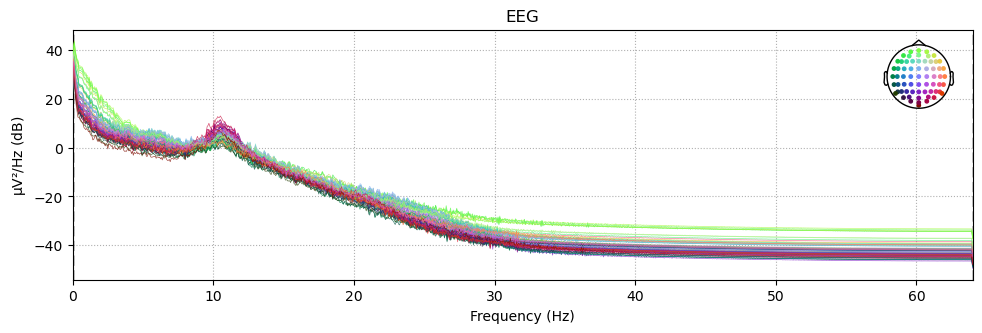

In [73]:
#check psd
mne.viz.plot_raw_psd(raw, fmin = 0, fmax = 64)

## ICA

In [74]:
ica = ICA(max_iter="auto", random_state=97)
ica.fit(raw)
ica

Fitting ICA to data using 64 channels (please be patient, this may take a while)


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_76635/3142827221.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by non-zero PCA components: 64 components
Fitting ICA took 5.8s.


Method,fastica
Fit,62 iterations on raw data (85120 samples)
ICA components,64
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


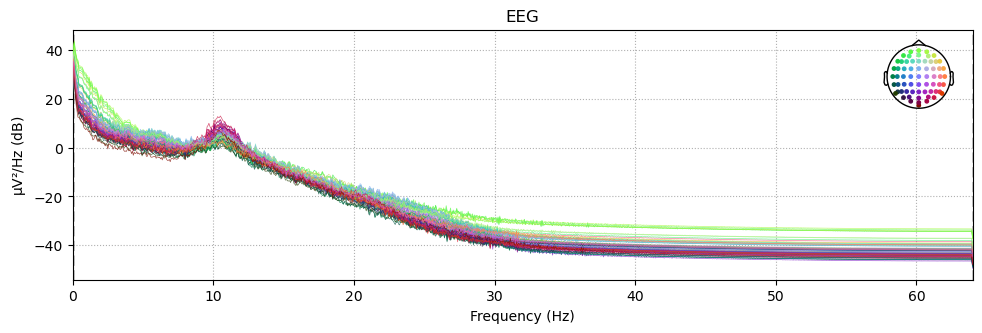

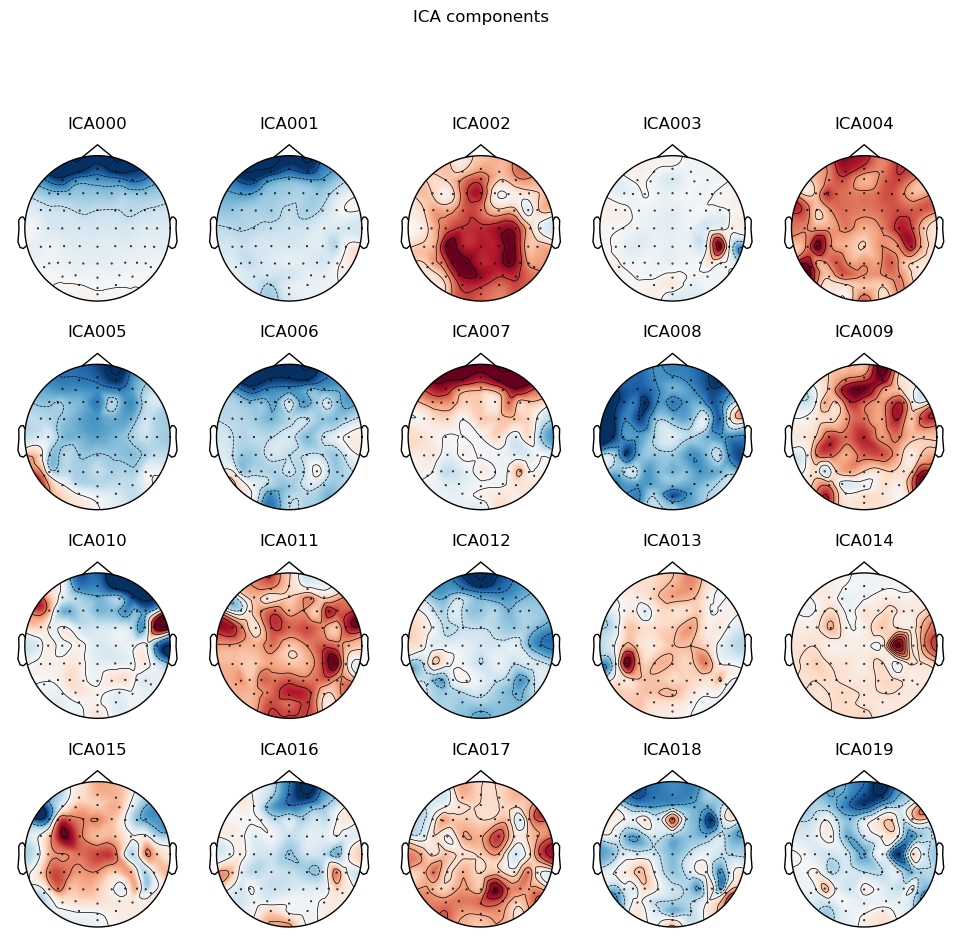

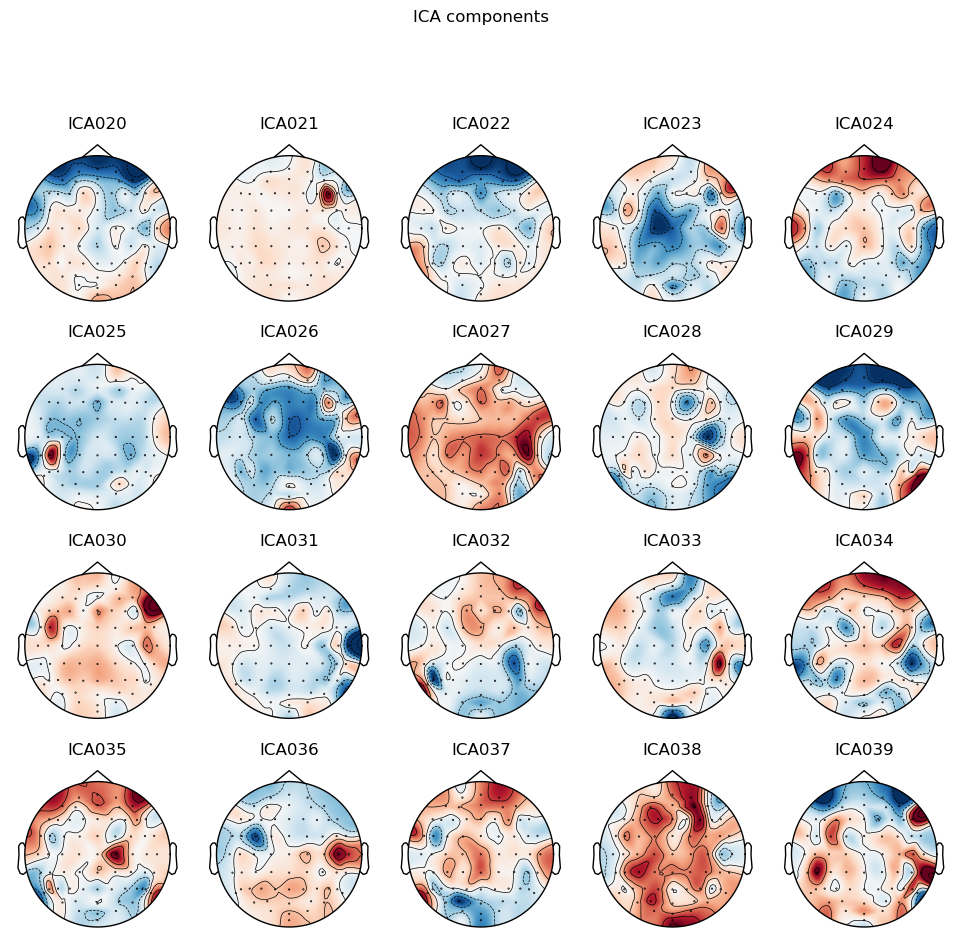

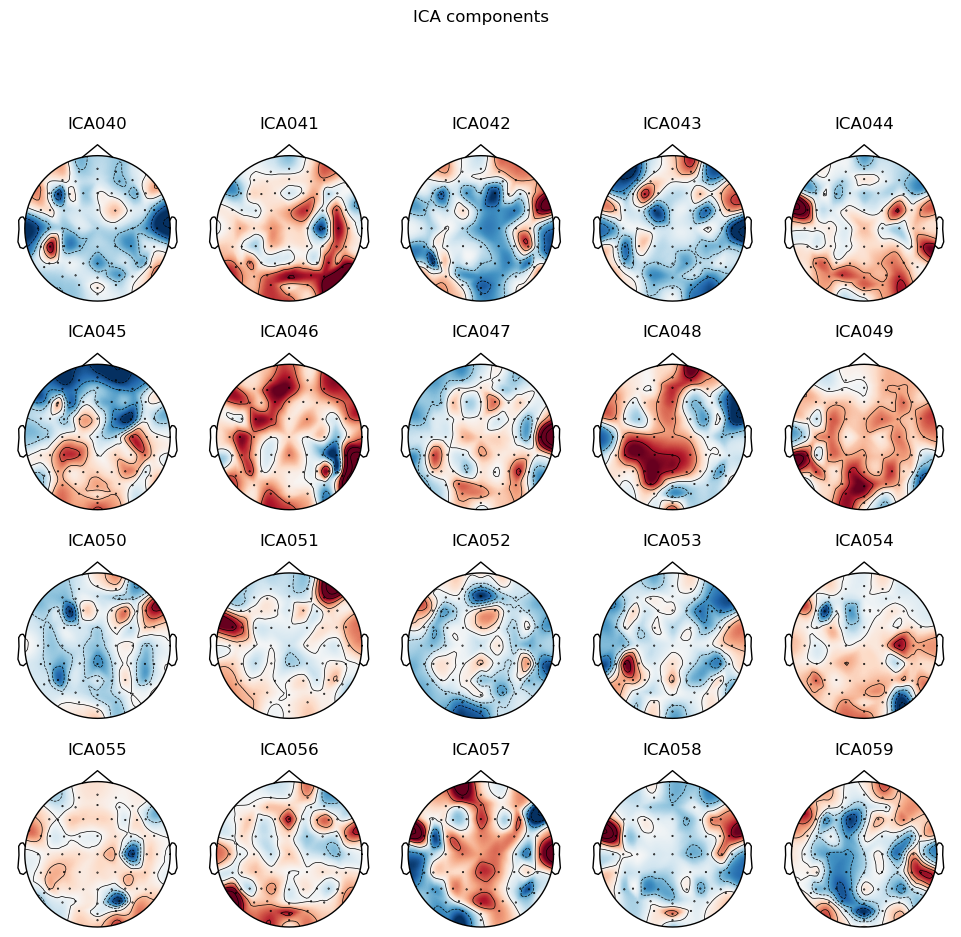

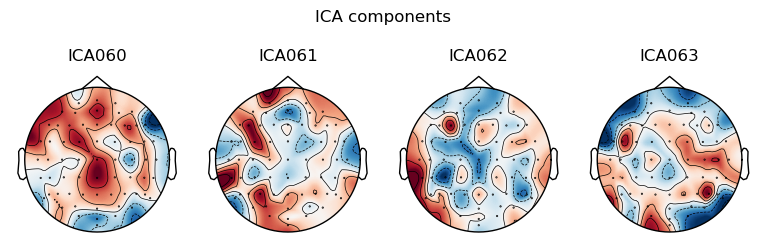

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 780x260.5 with 4 Axes>]

In [75]:
ica.plot_components()

In [81]:
ica.exclude = [0,1]
reconst_raw = raw.copy()
ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


<RawArray | 64 x 85120 (665.0 s), ~41.6 MB, data loaded>

## PLOTS

All keystroke ERPs

In [82]:
events_arr = make_raw_events(events_sv)
t_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==2])

Not setting metadata
328 matching events found
Setting baseline interval to [-0.296875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 328 events and 129 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


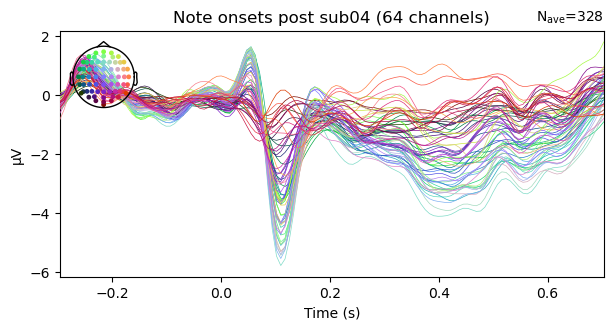

In [83]:
epochs = mne.Epochs(reconst_raw, t_keystrokes, tmin=-0.3, tmax=0.7, preload=True)
#fig = epochs.plot(events=t_keystrokes)
evoked = epochs.average()
fig = evoked.plot(titles = f'Note onsets {period} sub{subject_ID}')
fig.savefig(f'{figure_folder}/{subject_ID}_listen_{period}.png')

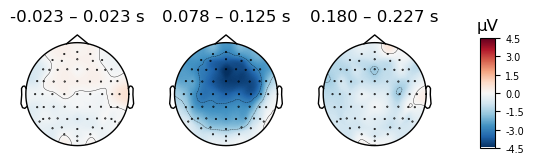

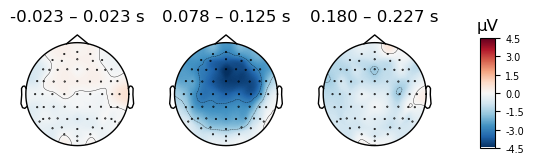

In [89]:
evoked.plot_topomap(times=[0,0.1, 0.2], average=0.05)

In [85]:
t_keystrokes.shape

(328, 3)